In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import os
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import IPython.display

In [67]:
# === 3. Преобразования изображений === #
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# === 4. Датасет === #
class LogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.logo_classes = os.listdir(root_dir)
        self.image_paths = {cls: [os.path.join(root_dir, cls, img) for img in os.listdir(os.path.join(root_dir, cls))] for cls in self.logo_classes}
        self.pairs = []
        self.labels = []
        self.create_pairs()
    
    def create_pairs(self):
        for cls in self.logo_classes:
            images = self.image_paths[cls]
            for _ in range(len(images) // 2):
                img1, img2 = random.sample(images, 2)
                self.pairs.append((img1, img2))
                self.labels.append(1)
        
        all_images = sum(self.image_paths.values(), [])
        for _ in range(len(self.pairs)):
            img1 = random.choice(all_images)
            img2 = random.choice(all_images)
            while os.path.dirname(img1) == os.path.dirname(img2):
                img2 = random.choice(all_images)
            self.pairs.append((img1, img2))
            self.labels.append(0)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [68]:
dataset = LogoDataset('dataset', transform=transform)
img1, img2, label = dataset.__getitem__(1)
print(img1.shape,img2.shape, label.shape)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([])


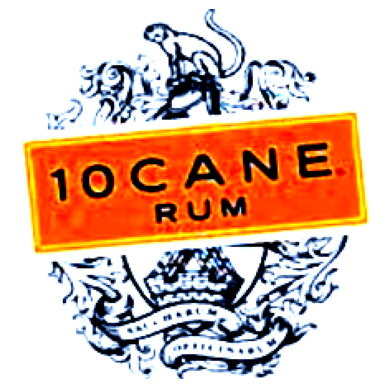

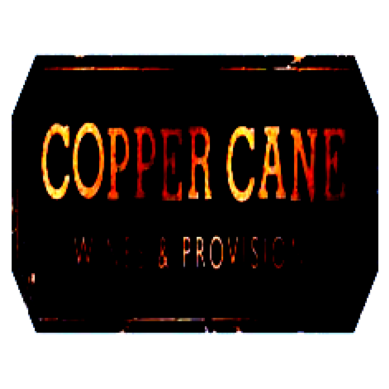

tensor(1.) ['10 Cane', '1519 Tequila', '241 Pizza', '2xist', '2XU', '3D-GOLD', '3nod', '3t cycling', '42 Below', '4Kids', '4Skins', '65amps', '66 North', '7-PE', '7-Up', '76', '7Days Inn', '85C Bakery Cafe', '999', 'A T CROSS', 'A. Marinelli', 'A. Turrent', 'A.P.C', 'Abacus 5', 'Abercrombie', 'Absolut', 'Absolwent', 'abus', 'ac propulsion', 'ACE Team', 'ACN', 'Acne Studios', 'ACQUA DI PARMA', 'Acratech', 'Act II', 'ActiPlus', 'ADCO', 'adika', 'Admiral Oversea Corporation', 'Adnams', 'Adobe Systems', 'ADOX', 'aeknil', 'Aethra', 'After Dinner', 'agv', 'Air Choice One Airlines', 'airmate', 'AiTeFu', 'AKG', 'akurra', 'Alba Botanica', 'alcan', 'Alcatel-1', 'alessi', 'ALFAPARF', 'alvedon', 'Ameriflight', 'Amerijet International', 'Ameristar Air Cargo', 'Amkette', 'Amoi', 'Amstrad', 'ANCAP-1', 'Apiretal', 'Aprilia', 'arrinera', 'artega', 'Artillery', 'Asics', 'aspirin', 'atamel', 'Audison', 'bahama breeze', 'band-aid', 'Baron von Redberry', "barrel o' monkeys", 'batman returns', 'battleship',

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для отображения изображения
def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Переводим tensor в формат для отображения
    img = np.clip(img, 0, 1)  # Обрезаем значения пикселей
    plt.imshow(img)
    plt.axis('off')  # Отключаем оси
    plt.show()

# Отображаем оба изображения
show_image(img1)
show_image(img2)
print(label, dataset.logo_classes)

In [70]:


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(label * torch.pow(euclidean_distance, 2) +
                          (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

    def forward_once(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        return x

    def forward(self, img1, img2):
        feat1 = self.forward_once(img1)
        feat2 = self.forward_once(img2)
        return feat1, feat2



In [71]:


# === 5. Обучение модели === #
def train(model, dataloader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for img1, img2, label in pbar:
                img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
                optimizer.zero_grad()
                output1, output2 = model(img1, img2)
                loss = criterion(output1, output2, label)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / len(dataloader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")


# === 6. Инициализация и запуск обучения === #
root_dir = "dataset"  # Укажи путь к папке с логотипами

dataset = LogoDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model = SiameseNetwork().cuda()  # Переносим модель на GPU
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, dataloader, criterion, optimizer)




c:\Users\mzhum\OneDrive\Pulpit\eficcientnet\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mzhum\OneDrive\Pulpit\eficcientnet\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30: 100%|██████████| 1489/1489 [01:25<00:00, 17.46it/s, loss=1.29]


Epoch [1/30], Loss: 1.2920


Epoch 2/30: 100%|██████████| 1489/1489 [01:22<00:00, 17.99it/s, loss=0.235]


Epoch [2/30], Loss: 0.2353


Epoch 3/30: 100%|██████████| 1489/1489 [01:22<00:00, 17.98it/s, loss=0.23] 


Epoch [3/30], Loss: 0.2299


Epoch 4/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.88it/s, loss=0.228]


Epoch [4/30], Loss: 0.2277


Epoch 5/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.92it/s, loss=0.229]


Epoch [5/30], Loss: 0.2293


Epoch 6/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.91it/s, loss=0.233]


Epoch [6/30], Loss: 0.2329


Epoch 7/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.76it/s, loss=0.248]


Epoch [7/30], Loss: 0.2476


Epoch 8/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.83it/s, loss=0.263]


Epoch [8/30], Loss: 0.2633


Epoch 9/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.90it/s, loss=0.26] 


Epoch [9/30], Loss: 0.2600


Epoch 10/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.84it/s, loss=0.255]


Epoch [10/30], Loss: 0.2553


Epoch 11/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.85it/s, loss=0.255]


Epoch [11/30], Loss: 0.2552


Epoch 12/30: 100%|██████████| 1489/1489 [01:22<00:00, 17.94it/s, loss=0.253]


Epoch [12/30], Loss: 0.2533


Epoch 13/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.90it/s, loss=0.255]


Epoch [13/30], Loss: 0.2553


Epoch 14/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.02it/s, loss=0.249]


Epoch [14/30], Loss: 0.2492


Epoch 15/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.94it/s, loss=0.249]


Epoch [15/30], Loss: 0.2494


Epoch 16/30: 100%|██████████| 1489/1489 [01:24<00:00, 17.73it/s, loss=0.251]


Epoch [16/30], Loss: 0.2510


Epoch 17/30: 100%|██████████| 1489/1489 [01:23<00:00, 17.91it/s, loss=0.245]


Epoch [17/30], Loss: 0.2447


Epoch 18/30: 100%|██████████| 1489/1489 [01:22<00:00, 17.98it/s, loss=0.242]


Epoch [18/30], Loss: 0.2421


Epoch 19/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.04it/s, loss=0.239]


Epoch [19/30], Loss: 0.2392


Epoch 20/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.03it/s, loss=0.237]


Epoch [20/30], Loss: 0.2367


Epoch 21/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.12it/s, loss=0.233]


Epoch [21/30], Loss: 0.2326


Epoch 22/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.13it/s, loss=0.233]


Epoch [22/30], Loss: 0.2327


Epoch 23/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.12it/s, loss=0.23] 


Epoch [23/30], Loss: 0.2296


Epoch 24/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.11it/s, loss=0.225]


Epoch [24/30], Loss: 0.2254


Epoch 25/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.15it/s, loss=0.222]


Epoch [25/30], Loss: 0.2218


Epoch 26/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.07it/s, loss=0.217]


Epoch [26/30], Loss: 0.2172


Epoch 27/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.03it/s, loss=0.213]


Epoch [27/30], Loss: 0.2133


Epoch 28/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.05it/s, loss=0.211]


Epoch [28/30], Loss: 0.2106


Epoch 29/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.02it/s, loss=0.205]


Epoch [29/30], Loss: 0.2054


Epoch 30/30: 100%|██████████| 1489/1489 [01:22<00:00, 18.10it/s, loss=0.199]

Epoch [30/30], Loss: 0.1990


In [89]:
def predict_similarity(model, image_path1, image_path2):
    model.eval()  # Переводим модель в режим инференса
    img1 = preprocess_image(image_path1).cuda()
    img2 = preprocess_image(image_path2).cuda()

    with torch.no_grad():  # Отключаем вычисление градиентов
        output1, output2 = model(img1, img2)
        distance = F.pairwise_distance(output1, output2)
    
    print(f"Euclidean Distance: {distance.item():.4f} for {image_path2}")
    if float(distance.item()) < 0.5:
        print("True")
    else:
        print("False")
    return distance.item()

for logo in os.listdir("test/samples"):
    predict_similarity(model, "test/organization/1.jpg", f"test/samples/{logo}")

Euclidean Distance: 0.4745 for test/samples/0.jpg
True
Euclidean Distance: 0.3694 for test/samples/01.jpg
True
Euclidean Distance: 0.3515 for test/samples/02.jpg
True
Euclidean Distance: 0.3072 for test/samples/03.jpg
True
Euclidean Distance: 0.3878 for test/samples/04.jpg
True
Euclidean Distance: 0.4171 for test/samples/0_0.jpg
True
Euclidean Distance: 0.5024 for test/samples/0_1.jpg
False
Euclidean Distance: 0.6330 for test/samples/0_2.jpg
False
Euclidean Distance: 0.6357 for test/samples/0_3.jpg
False
Euclidean Distance: 0.5781 for test/samples/1.jpg
False
Euclidean Distance: 0.4367 for test/samples/2.jpg
True
Euclidean Distance: 0.2128 for test/samples/3.jpg
True


In [90]:
save_dir = 'mod'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'model.pth')
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to mod\model.pth
